In [35]:
import pandas as pd

In [36]:
user_paths = pd.read_csv("data/processed/user_paths.csv")
first_touch = pd.read_csv("data/processed/first_touch_table.csv")
last_touch = pd.read_csv("data/processed/last_touch_table.csv")
linear_credit = pd.read_csv("data/processed/linear_credit_prep.csv")
transitions = pd.read_csv("data/processed/transitions_edges.csv")

In [37]:
print("\nShapes:")
print("user_paths:", user_paths.shape)
print("first_touch:", first_touch.shape)
print("last_touch:", last_touch.shape)
print("linear_credit:", linear_credit.shape)
print("transitions:", transitions.shape)

print("\nQuick look at user_paths:")
print(user_paths.head())


Shapes:
user_paths: (2847, 10)
first_touch: (6, 3)
last_touch: (6, 3)
linear_credit: (3860, 4)
transitions: (54, 3)

Quick look at user_paths:
   User ID                                   Path  Path_Conversion  \
0    10028                             Search Ads                1   
1    10045               Search Ads > Display Ads                1   
2    10062  Social Media > Direct Traffic > Email                1   
3    10068                             Search Ads                1   
4    10095                            Display Ads                1   

   path_length  n_unique_channels first_channel last_channel  \
0            1                  1    Search Ads   Search Ads   
1            2                  2    Search Ads  Display Ads   
2            3                  3  Social Media        Email   
3            1                  1    Search Ads   Search Ads   
4            1                  1   Display Ads  Display Ads   

                  path_start                   pat

In [38]:
n_paths = len(user_paths)
n_converters = user_paths["Path_Conversion"].sum()
n_channels = pd.concat([
    user_paths["first_channel"], user_paths["last_channel"]
]).nunique()

print("\nSanity Checks:")
print("Number of paths:", n_paths)
print("Number of converters:", n_converters)
print("Number of unique channels (first/last):", n_channels)


Sanity Checks:
Number of paths: 2847
Number of converters: 2381
Number of unique channels (first/last): 6


In [39]:
import matplotlib.pyplot as plt


In [40]:
first_touch_attr = (
    user_paths[user_paths["Path_Conversion"] == 1]
    .groupby("first_channel")["Path_Conversion"]
    .sum()
    .rename("First_Touch")
)

In [41]:
last_touch_attr = (
    user_paths[user_paths["Path_Conversion"] == 1]
    .groupby("last_channel")["Path_Conversion"]
    .sum()
    .rename("Last_Touch")
)

In [42]:
lin_attr = (
    linear_credit.groupby("channel")["User ID"]
    .nunique()  # unique users per channel in converting paths
    .rename("Linear")
)

In [43]:
attribution_summary = (
    pd.concat([first_touch_attr, last_touch_attr, lin_attr], axis=1)
      .fillna(0)
      .astype(int)
      .reset_index()
      .rename(columns={"index": "Channel"})
)

In [44]:
attribution_summary["Total_Credit"] = (
    attribution_summary["First_Touch"]
    + attribution_summary["Last_Touch"]
    + attribution_summary["Linear"]
)

In [45]:
print("Attribution summary (head):")
print(attribution_summary.head())

Attribution summary (head):
          Channel  First_Touch  Last_Touch  Linear  Total_Credit
0  Direct Traffic          411         402     582          1395
1     Display Ads          428         415     608          1451
2           Email          374         391     566          1331
3        Referral          408         412     611          1431
4      Search Ads          371         349     545          1265


In [46]:
attribution_summary_melted = attribution_summary.melt(
    id_vars="Channel",
    value_vars=["First_Touch", "Last_Touch", "Linear"],
    var_name="Attribution_Model",
    value_name="Conversions"
)


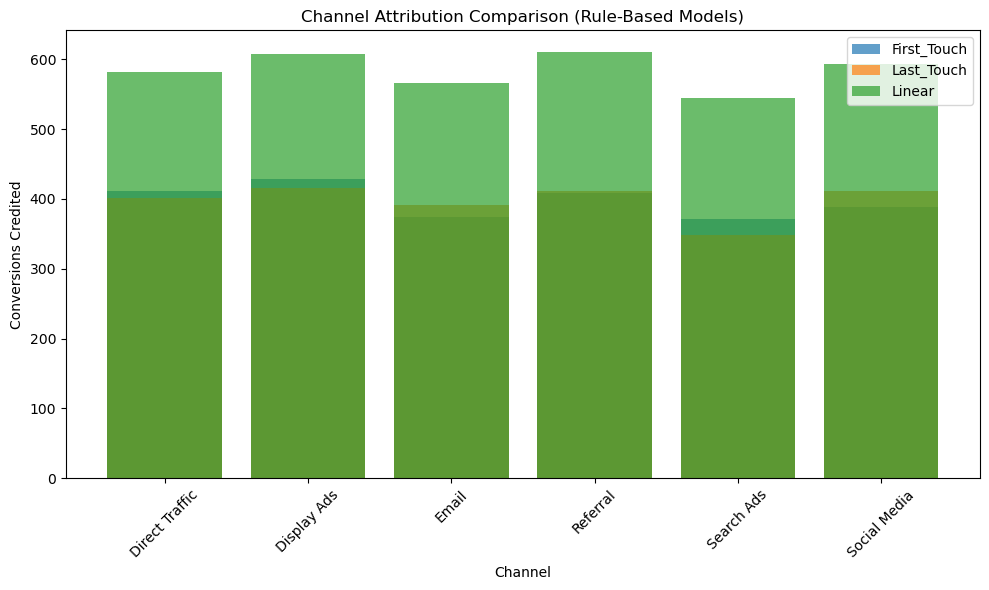

In [47]:
plt.figure(figsize=(10,6))
for model in ["First_Touch", "Last_Touch", "Linear"]:
    subset = attribution_summary_melted[attribution_summary_melted["Attribution_Model"] == model]
    plt.bar(subset["Channel"], subset["Conversions"], label=model, alpha=0.7)

plt.title("Channel Attribution Comparison (Rule-Based Models)")
plt.xlabel("Channel")
plt.ylabel("Conversions Credited")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
import numpy as np


In [49]:
edges = pd.read_csv("data/processed/transitions_edges.csv")


In [50]:
required_cols = {"from_channel", "to_channel", "weight"}
missing = required_cols - set(edges.columns)
if missing:
    raise ValueError(f"Missing columns in transitions_edges.csv: {missing}")


In [51]:
states = sorted(set(edges["from_channel"]).union(edges["to_channel"]))

In [52]:
idx = {s: i for i, s in enumerate(states)}
P = np.zeros((len(states), len(states)), dtype=float)

for _, row in edges.iterrows():
    i = idx[row["from_channel"]]
    j = idx[row["to_channel"]]
    P[i, j] += row["weight"]

In [53]:
row_sums = P.sum(axis=1, keepdims=True)
with np.errstate(divide="ignore", invalid="ignore"):
    P = np.where(row_sums > 0, P / row_sums, 0.0)

In [54]:
for absorbing_state in ["Conversion", "Null"]:
    if absorbing_state in idx:
        r = idx[absorbing_state]
        P[r, :] = 0.0
        P[r, r] = 1.0


In [55]:
print("States:", states)
print("Transition matrix shape:", P.shape)

States: ['Conversion', 'Direct Traffic', 'Display Ads', 'Email', 'Null', 'Referral', 'Search Ads', 'Social Media', 'Start']
Transition matrix shape: (9, 9)


In [56]:
def conversion_probability(P, states, start_label="Start",
                           conversion_label="Conversion", null_label="Null"):
    """
    Returns the probability of eventually being absorbed in Conversion,
    starting from Start, in an absorbing Markov chain with absorbing states
    Conversion and (optionally) Null.
    """
    if start_label not in states or conversion_label not in states:
        return np.nan  # not enough structure to compute

    absorbing = []
    for s in states:
        i = states.index(s)
        # A row is absorbing if it is [0..0,1 at diagonal]
        absorbing.append(np.isclose(P[i, i], 1.0) and np.isclose(P[i].sum(), 1.0))
    absorbing_idx = [i for i, a in enumerate(absorbing) if a]
    transient_idx = [i for i, a in enumerate(absorbing) if not a]

    if not absorbing_idx or not transient_idx:
        return np.nan

    order = transient_idx + absorbing_idx
    inv = {old: new for new, old in enumerate(order)}
    P_ord = P[np.ix_(order, order)]

    t = len(transient_idx)
    Q = P_ord[:t, :t]
    R = P_ord[:t, t:]  

    I = np.eye(t)
    try:
        N = np.linalg.inv(I - Q)
    except np.linalg.LinAlgError:
        return np.nan

    B = N @ R  # shape (t, #absorbing)

    start_t = inv[states.index(start_label)]
    abs_states = [states[i] for i in absorbing_idx]
    if conversion_label not in abs_states:
        return np.nan
    conv_col = abs_states.index(conversion_label)

    return float(B[start_t, conv_col])


Baseline conversion probability (Start → Conversion): 0.8363


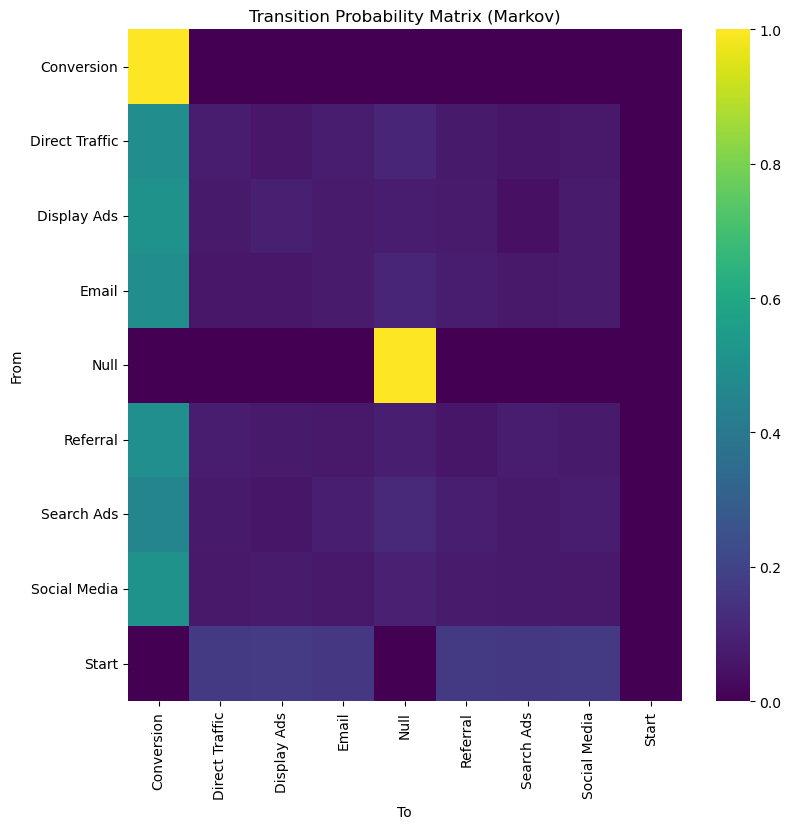

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

baseline_conv_prob = conversion_probability(P, states)
print(f"Baseline conversion probability (Start → Conversion): {baseline_conv_prob:.4f}")

plt.figure(figsize=(min(12, 0.6*len(states)+3), min(10, 0.6*len(states)+3)))
sns.heatmap(P, xticklabels=states, yticklabels=states, cmap="viridis")
plt.title("Transition Probability Matrix (Markov)")
plt.xlabel("To")
plt.ylabel("From")
plt.tight_layout()
plt.show()


In [58]:
def build_P_from_edges(edges_df):
    st = sorted(set(edges_df["from_channel"]).union(edges_df["to_channel"]))
    idx_local = {s: i for i, s in enumerate(st)}
    P_local = np.zeros((len(st), len(st)), dtype=float)
    for _, row in edges_df.iterrows():
        i = idx_local[row["from_channel"]]
        j = idx_local[row["to_channel"]]
        P_local[i, j] += row["weight"]
    rs = P_local.sum(axis=1, keepdims=True)
    with np.errstate(divide="ignore", invalid="ignore"):
        P_local = np.where(rs > 0, P_local / rs, 0.0)
    for a in ["Conversion", "Null"]:
        if a in idx_local:
            r = idx_local[a]
            P_local[r, :] = 0.0
            P_local[r, r] = 1.0
    return P_local, st

special = {"Start", "Conversion", "Null"}
candidate_channels = [s for s in states if s not in special]

removal_rows = []
for ch in candidate_channels:
    pruned = edges[(edges["from_channel"] != ch) & (edges["to_channel"] != ch)].copy()

 
    P_rm, st_rm = build_P_from_edges(pruned)
    conv_prob_rm = conversion_probability(P_rm, st_rm)

    if np.isnan(conv_prob_rm) or baseline_conv_prob == 0:
        drop_pct = np.nan
    else:
        drop_pct = max(0.0, (baseline_conv_prob - conv_prob_rm) / baseline_conv_prob)

    removal_rows.append({
        "channel": ch,
        "conv_prob_after_removal": conv_prob_rm,
        "drop_pct": drop_pct
    })

markov_contrib = (
    pd.DataFrame(removal_rows)
      .sort_values("drop_pct", ascending=False)
      .reset_index(drop=True)
)

print("Markov removal effect (top 10):")
print(markov_contrib.head(10))


Markov removal effect (top 10):
          channel  conv_prob_after_removal  drop_pct
0     Display Ads                 0.831251  0.006059
1        Referral                 0.832954  0.004023
2    Social Media                 0.834259  0.002463
3  Direct Traffic                 0.838975  0.000000
4           Email                 0.838093  0.000000
5      Search Ads                 0.842151  0.000000


In [59]:
from pathlib import Path

Path("data/processed").mkdir(parents=True, exist_ok=True)

pd.DataFrame(P, index=states, columns=states).to_csv("data/processed/transition_matrix_prob.csv")
markov_contrib.to_csv("data/processed/markov_channel_importance.csv", index=False)

print("Saved transition_matrix_prob.csv and markov_channel_importance.csv to data/processed/")


Saved transition_matrix_prob.csv and markov_channel_importance.csv to data/processed/


In [60]:
rb = attribution_summary.copy()
rb["Channel"] = rb["Channel"].astype(str)


In [61]:
mk = markov_contrib.rename(columns={"channel": "Channel"}).copy()
mk["Channel"] = mk["Channel"].astype(str)
mk["Markov_Weight"] = mk["drop_pct"].clip(lower=0)

In [62]:
for col in ["First_Touch", "Last_Touch", "Linear"]:
    total = rb[col].sum()
    rb[f"{col}_Share"] = rb[col] / total if total else 0

mk["Markov_Share"] = mk["Markov_Weight"] / mk["Markov_Weight"].sum() if mk["Markov_Weight"].sum() else 0


In [63]:
comparison = (
    rb.merge(mk[["Channel", "Markov_Share", "drop_pct"]], on="Channel", how="outer")
      .fillna(0)
)

In [64]:
comparison["Last_minus_Markov"]  = comparison["Last_Touch_Share"]  - comparison["Markov_Share"]
comparison["First_minus_Markov"] = comparison["First_Touch_Share"] - comparison["Markov_Share"]
comparison["Linear_minus_Markov"]= comparison["Linear_Share"]       - comparison["Markov_Share"]


In [65]:
overrated = comparison.sort_values("Last_minus_Markov", ascending=False).head(3)
undervalued = comparison.sort_values("Last_minus_Markov", ascending=True).head(3)


In [66]:
print("Channels that look overrated by LAST-TOUCH (relative to Markov):")
print(overrated[["Channel", "Last_Touch_Share", "Markov_Share", "Last_minus_Markov"]])

print("\nChannels that look undervalued until you apply MARKOV:")
print(undervalued[["Channel", "Last_Touch_Share", "Markov_Share", "Last_minus_Markov"]])


Channels that look overrated by LAST-TOUCH (relative to Markov):
          Channel  Last_Touch_Share  Markov_Share  Last_minus_Markov
0  Direct Traffic          0.168837           0.0           0.168837
2           Email          0.164217           0.0           0.164217
4      Search Ads          0.146577           0.0           0.146577

Channels that look undervalued until you apply MARKOV:
        Channel  Last_Touch_Share  Markov_Share  Last_minus_Markov
1   Display Ads          0.174297      0.483006          -0.308710
3      Referral          0.173037      0.320690          -0.147653
5  Social Media          0.173037      0.196304          -0.023267


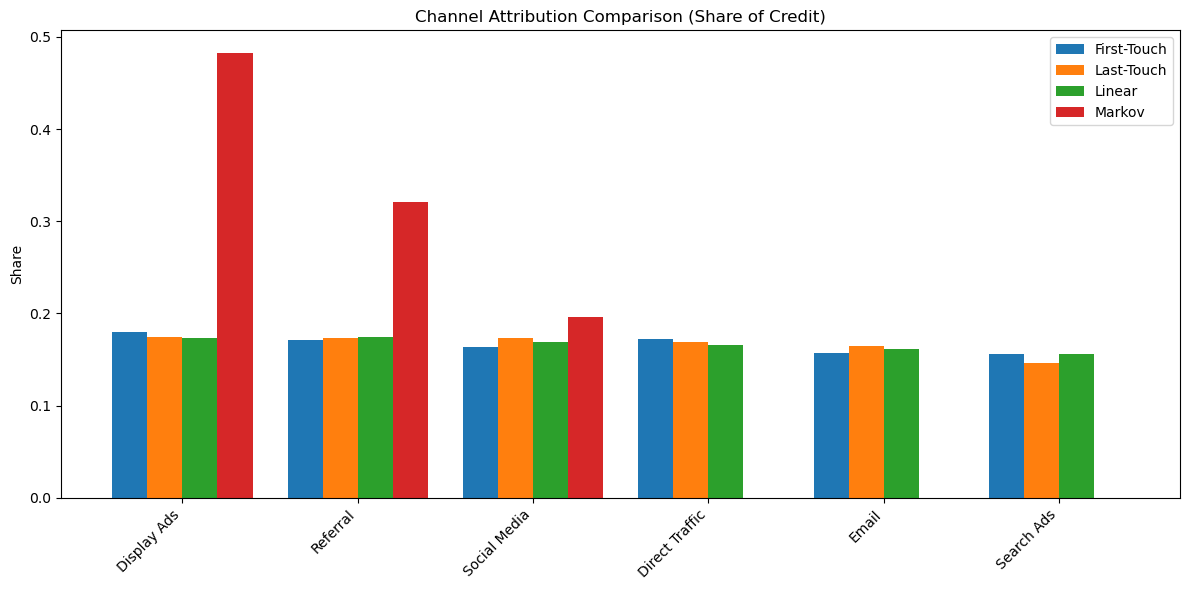

In [67]:
N = 10
comparison["Any_Share"] = (
    comparison["First_Touch_Share"] + comparison["Last_Touch_Share"]
    + comparison["Linear_Share"] + comparison["Markov_Share"]
)
topN = (comparison.sort_values("Any_Share", ascending=False).head(N)
        .copy()
        .sort_values("Markov_Share", ascending=False))  # sort by Markov for focus

labels = topN["Channel"].tolist()
x = range(len(labels))

plt.figure(figsize=(12,6))
width = 0.2
plt.bar([i - 1.5*width for i in x], topN["First_Touch_Share"],  width=width, label="First-Touch")
plt.bar([i - 0.5*width for i in x], topN["Last_Touch_Share"],   width=width, label="Last-Touch")
plt.bar([i + 0.5*width for i in x], topN["Linear_Share"],       width=width, label="Linear")
plt.bar([i + 1.5*width for i in x], topN["Markov_Share"],       width=width, label="Markov")

plt.title("Channel Attribution Comparison (Share of Credit)")
plt.ylabel("Share")
plt.xticks(list(x), labels, rotation=45, ha="right")
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
Path("data/processed").mkdir(parents=True, exist_ok=True)
rb.to_csv("data/processed/rule_based_attribution.csv", index=False)
mk[["Channel", "drop_pct", "Markov_Share"]].to_csv("data/processed/markov_attribution.csv", index=False)
comparison.to_csv("data/processed/attribution_comparison.csv", index=False)
